In [7]:
import sys
import os
from time import time
import pymc as pm
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from typing import List
import scipy.stats as stats
import pytensor.tensor as at
import pytensor.tensor.slinalg as sla
import pytensor
import warnings
import arviz as az
print(f"Running on PyMC v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
#from easydl import clear_output
from IPython.display import clear_output

Running on PyMC v5.2.0


In [8]:
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation import static_layers
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.map_expansion import arcline_path_utils
from pyquaternion import Quaternion
from nuscenes.eval.common.utils import quaternion_yaw

In [9]:
from utils_map import *

In [10]:
hyper_parameters = {
    'split' : 'val',
    'data_root' : '/home/hncui/share/Nuscenes/nu_data',

    'num_states' : 21,      #HMM相关超参数
    'acc_min' : -5,         #最小加速度
    'acc_max' : 5,          #最大加速度
    'acc_sigma' : 0.15,     #加速度方差
    'psi_min' : -0.3,       #最小转向角
    'psi_max' : 0.3,        #最大转向角
    'psi_sigma' : 0.01,     #转向角方差
    'dt' : 0.5,             #时间间隔
    'pre_calculated' : True,#是否使用提前计算好的参数
    
    #地图生成超参数

    'discretization_resolution_meters' : 1, #车道分割分辨率
    'lane_node_radius' : 5, #车道搜索后继结点半径
    'lane_direction_threshold' : np.pi / 2,  #车道后继节点方向阈值，大于该值不作为后继节点
    
    #输入数据超参数
    'data_input_radius' : 20,   #输入数据中周围移动物体检测半径
    
    #sample 超参数
    'bezier_factor' : 5, #贝塞尔距离乘系数
    'bezier_offset' : 5, #贝塞尔距离偏移系数
    'bezier_exp' : 5, #贝塞尔指数系数
    
    
}

In [11]:
DATAROOT=hyper_parameters['data_root']
nusc = NuScenes(version='v1.0-trainval', dataroot=DATAROOT, verbose=True)   # v1.0-trainval     v1.0-mini
helper = PredictHelper(nusc)
token_list = get_prediction_challenge_split(hyper_parameters['split'], dataroot=DATAROOT)    # train val mini_train mini_val四个数据集
maps = static_layers.load_all_maps(helper)

Loading NuScenes tables for version v1.0-trainval...


23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 47.441 seconds.
Reverse indexing ...
Done reverse indexing in 13.7 seconds.


In [12]:
Vertices_maps, Edges_maps, ordered_x_maps, ordered_y_maps, lanes_vertices = generate_maps(maps) #生成地图
#   Vertices_maps:dict(),key为地图名,value为各个地图中的节点集
#   Edges_maps:同上，边集
#   ordered_x_maps:同上，按照x坐标排序的点集
#   ordered_y_maps:同上，按照y坐标排序的点集
#   lane_vertices:dict(),key为车道token，value为车道点列表
lane_dir_diffs = set_lanes_mode(lanes_vertices) #计算车道为左转、直行、右转中的哪一个

In [13]:
X = [] #输入数据

for token in token_list:
    instance_token, sample_token = token.split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    X.append(ann)

In [14]:
%load_ext autoreload
%autoreload 2
from utils_sample import *
import copy
from utils_social_field import *
from utils_data_input import get_label, get_sample_input, get_moving_static_inputs
colors = {
    'animal':'aqua',
    'human':'green',
    'object':'grey',
    'cycle':'yellow',
    'vehicle':'blue',
    'lane':'tan'
}

In [15]:
gt_all, subsequences_X = get_label(helper, X)       #计算ground truth
sample_input = get_sample_input(helper, nusc, X)    #输入数据按类型分类
static_inputs, moving_inputs, moving_anns = get_moving_static_inputs(X, sample_input, helper) 
#静态障碍物，移动障碍物

In [16]:
from matplotlib.patches import Rectangle

In [17]:
from utils_HMM import get_HMM
N_STATES = hyper_parameters['num_states']
mu_a = np.linspace(-5,5,N_STATES)
mu_psi = np.linspace(-0.3, 0.3, N_STATES)
if hyper_parameters['pre_calculated']:
    P_trans_a_history = np.load('./checkpoints/P_trans_a_history_np3.16_2.npy')
    P_trans_psi_history = np.load('./checkpoints/P_trans_psi_history_np3.16_2.npy')
else:
    P_trans_a_history, P_trans_psi_history = get_HMM(nusc, helper, token_list, hyper_parameters)
p_trans_a = P_trans_a_history[-1]
p_trans_psi = P_trans_psi_history[-1]
#p_trans_a = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_a_3.17_1_21states.npy')
#p_trans_psi = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_psi_3.17_1_21states.npy')
p_trans_a = p_trans_a / p_trans_a.sum(axis = 1)
p_trans_psi = p_trans_psi / p_trans_psi.sum(axis = 1)
def np_solve_equilibrium(p_transition):
    n_states = len(p_transition)
    A = np.eye(n_states) - p_transition + np.ones(shape=(n_states,n_states))
    p_equilibrium = np.linalg.solve(A.T,np.ones(shape=(n_states)))
    return p_equilibrium
p_eq_a = np_solve_equilibrium(p_trans_a)
p_eq_psi = np_solve_equilibrium(p_trans_psi)
p_eq_a = p_eq_a / p_eq_a.sum()
p_eq_psi = p_eq_psi / p_eq_psi.sum()
true_sigma_a = np.ones(N_STATES) * 0.15
true_sigma_psi = np.ones(N_STATES) * 0.01

Running on PyMC v5.2.0


In [18]:
psi_rv = stats.norm(loc = mu_psi, scale = true_sigma_psi)
a_rv = stats.norm(loc = mu_a, scale = true_sigma_a)

model = pm.Model()
with model:
    P_trans = pm.MutableData('P_trans', p_trans_a)
    mu = pm.MutableData('mu', np.ones(N_STATES))
    sigma  = pm.MutableData('sigma', np.ones(N_STATES))
    obs_seq = pm.MutableData('obs_seq', np.ones((5,1)))
    P_init = pm.Dirichlet('P_init', a=np.ones((N_STATES,)), shape=(N_STATES,))
    a = pm.DensityDist('a', mu, sigma, P_init, P_trans, N_STATES, logp=mylogp, observed = obs_seq)

In [19]:
eps = 1e-100
v_fix_vector = np.arange(N_STATES) - (N_STATES // 2)
k_v = 1e-0
v_mean = 6.2541808327494905
a_rvs = []
psi_rvs = []
for i in range(N_STATES):
    a_rvs.append(stats.norm(loc = mu_a[i], scale = true_sigma_a[i]))
    psi_rvs.append(stats.norm(loc = mu_psi[i], scale = true_sigma_psi[i]))

In [20]:
all_agents = []
all_moving = []
all_static = []
from utils_data_input import get_field_input
for i in range(0, len(X)):
    main_agent = X[i]
    sample_token = main_agent['sample_token']
    instance_token = main_agent['instance_token']
    moving_agents = moving_anns[instance_token + '_' + sample_token]

    predict_agents = moving_agents + [main_agent]
    moving_input = copy.deepcopy(moving_inputs[instance_token + '_' + sample_token])
    get_field_input(main_agent, None, moving_input, True, helper = helper)
    static_input = static_inputs[instance_token + '_' + sample_token]

    all_agents.append(predict_agents)
    all_moving.append(moving_input)
    all_static.append(static_input)

In [21]:
def plot_agent(annotation, ax, clr = None):
    width = annotation['size'][1]
    height = annotation['size'][0]
    translation = annotation['translation']
    xy = (translation[0] - width / 2, translation[1] - height / 2)
    angle = quaternion_yaw(Quaternion(annotation['rotation'])) / np.pi * 180
    if clr is None:
        clr = 'green'
    box = Rectangle(xy, width, height, angle = angle, rotation_point = 'center', color = clr, alpha = 0.5)
    ax.add_patch(box)
    ax.set_xlim(translation[0] - 30, translation[0] + 30)
    ax.set_ylim(translation[1] - 30, translation[1] + 30)
def plot_lane(lanes_vertices, lane_token, closest_idx, ax):
    lane = lanes_vertices[lane_token]
    x = []
    y = []
    for node in lane:
        x.append(node.coors[0])
        y.append(node.coors[1])
    for i in range(len(x) - 1):
        ax.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], length_includes_head = True, head_width = 0.3, color = 'blue')
    if closest_idx is not None:
        ax.scatter(x[closest_idx], y[closest_idx])

In [22]:
seed = 12345
np.random.seed(seed)
idxes = np.arange(0,len(X),1)
idxes = np.random.permutation(idxes)

In [17]:
from multiprocessing import Pool
model_2 = None

with Pool(16) as p:
    init_res = p.starmap(sample_predict_func_2, [(all_agents[i], all_moving[i], all_static[i], helper, 
                                               model_2, p_trans_a, mu_a, true_sigma_a, p_trans_psi, 
                                               mu_psi, true_sigma_psi, a_rv, psi_rv, p_eq_a, p_eq_psi, 
                                               maps, Vertices_maps, ordered_x_maps, ordered_y_maps, a_rvs, 
                                               psi_rvs, lanes_vertices, i, seed)for i in idxes])
    p.close()
    p.join()

start:3901
start:8532
end:8532, use time:11.25563213834539
start:8065
end:8065, use time:27.75839526206255
start:5502
end:3901, use time:87.29963888088241
start:7935
start:511
end:7935, use time:27.942788844928145
start:8607
end:8607, use time:8.763372255023569
start:51
start:7887
end:51, use time:9.74532295204699
start:5465
end:7887, use time:14.41020520683378
start:4049
end:5502, use time:67.08414385700598
start:1116
end:511, use time:73.36852378584445
start:1553
end:4049, use time:19.33966980688274
start:3004
start:5145
end:1116, use time:26.601084046065807
start:4291
end:1553, use time:20.18937171297148
start:1001
end:4291, use time:10.024982393253595
start:15
end:3004, use time:39.398748874198645
start:2863
end:15, use time:17.05366623820737
start:7147
end:5145, use time:34.07884141569957
start:6153
start:4040
end:1001, use time:36.61687287827954
start:6331
end:4040, use time:13.242248208727688
start:32
end:6153, use time:19.707876150961965
start:8284
end:7147, use time:24.7456636

In [18]:
temp_res = [None] * len(init_res)
for i in range(len(idxes)):
    temp_res[idxes[i]] = init_res[i]
all_res = temp_res
#all_res = init_res

In [23]:
gt_all = np.array(gt_all)
gt_x = gt_all[:,:,0]
gt_y = gt_all[:,:,1]
gt_x.shape, gt_y.shape

((9041, 12), (9041, 12))

In [5]:
main_x = []
main_y = []
c_gt_x = []
c_gt_y = []
for i in range(len(all_res)):
    if type(all_res[i][0]) == type(None):
        print(i)
    else:
        main_x.append(all_res[i][0])
        main_y.append(all_res[i][1])
        c_gt_x.append(gt_x[i])
        c_gt_y.append(gt_y[i])
c_gt_x = np.array(c_gt_x)
c_gt_y = np.array(c_gt_y)

NameError: name 'all_res' is not defined

In [21]:
time.ctime()

'Tue Jun  6 01:41:36 2023'

In [24]:
for i in range(len(main_x)):
    if len(main_x[i])!=1000:
        print(i, len(main_x[i]))

7300 937


In [22]:
ans_x = np.array(main_x)
ans_y = np.array(main_y)
np.save(hyper_parameters['split']+time.ctime()+'_ans_x.npy', ans_x)
np.save(hyper_parameters['split']+time.ctime()+'_ans_y.npy', ans_y)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9041,) + inhomogeneous part.

In [38]:
main_x = np.load('val_ans_x_6_2.npy')
main_y = np.load('val_ans_y_6_2.npy')

In [27]:
c_gt_x = gt_x
c_gt_y = gt_y

In [39]:
min_ade1000 = []
for i in range(len(main_x)):
    xs = main_x[i]
    ys = main_y[i]
    x_diff = xs - c_gt_x[i]
    y_diff = ys - c_gt_y[i]
    ade = np.sqrt(x_diff ** 2 + y_diff ** 2)
    min_ade1000.append(ade.mean(axis = 1).min())

min_ade1000 = np.array(min_ade1000)

In [40]:
min_ade1000, min_ade1000.mean()

(array([0.3883679 , 0.29919941, 0.22743042, ..., 0.47726891, 0.51042317,
        0.33660292]),
 0.7387385161855786)

In [ ]:
0.8156525930205659,1.7054073300981205   #速度平方
0.8593595347086217,1.7220209100761334   #概率分布
0.8179309544370765,1.7366980636411484   #速度平方，初始修改
0.8170016367603912,1.6995562417551129   #速度绝对值
0.810242235734287 ,1.6620017932139126   #速度绝对值，所有agent
0.8132917257743546,1.7102435377703245   #速度绝对值，所有agent，-2速度阈值

0.824640109542585,1.6424829583968492    #社会力阈值0.3，速度绝对值，所有agent,alpha = 0.1
0.8183923659146181,1.578904503294201    #社会力阈值0.3，速度绝对值，所有agent,alpha = 0.2
0.8098386903057428,1.5988376259016204   #社会力阈值0.3，速度绝对值，所有agent,alpha = 0.25
0.8006065987052934,1.8574632200793648
0.755736977739587,1.8316635387683968
0.8438762324214958,1.891170629864277

In [116]:
def plot_scene(ann, helper, ax, radius = 60):
    anns = helper.get_annotations_for_sample(ann['sample_token'])
    for t_ann in anns:
        if len(t_ann['attribute_tokens']):#没有attribute的情况
            attribute = nusc.get('attribute', t_ann['attribute_tokens'][0])
        else:
            attribute = None
        #print(attribute)
        #if 'vehicle' in attribute['name']:
        if t_ann['token'] == ann['token']:
            color = 'red'
        elif attribute is None or 'moving' in attribute['name'] or 'stopped' in attribute['name']:
            color = 'green'
        else:
            color = 'blue'
        plot_agent(t_ann, ax, color)
    translation = ann['translation']
    ax.set_xlim(translation[0] - radius, translation[0] + radius)
    ax.set_ylim(translation[1] - radius, translation[1] + radius)
    map_name = helper.get_map_name_from_sample_token(ann['sample_token'])
    Vertices = Vertices_maps[map_name]
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    lanes_token = get_lanes_in_radius(translation[0], translation[1], radius, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    
    for j in range(len(lanes_token)):
        lane_token = lanes_token[j]
        plot_lane(lanes_vertices, lane_token, None, ax)

In [ ]:
'''
figsize(15,15)
for i in range(len(main_x)):
    if min_ade1000[i] > 0:
        total_i = idxes[i]
        fig, ax = plt.subplots()
        plot_scene(X[total_i], helper, ax)
        ax.plot(gt_x[total_i], gt_y[total_i], color = 'red')
        ax.scatter(main_x[i], main_y[i], s= 1, alpha=0.5)
        fig.savefig('./mini_val_5_31/fig_{}_pred_all.png'.format(total_i))
        plt.close()
'''

In [52]:
single_main_x = np.load('/home/hncui/data/Nuscenes/mypython/release/valMon Jun  5 12:17:50 2023_ans_x_single.npy')
single_main_y = np.load('/home/hncui/data/Nuscenes/mypython/release/valMon Jun  5 12:17:51 2023_ans_y_single.npy')

In [41]:
figsize(15,15)
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
pred_5_x = []
pred_5_y = []
pred_10 = []
n_clusters = 5
n_res = 5
for i in range(len(main_x)):
    #clear_output()
    #print(i)
    
    pred_x = main_x[i]
    pred_y = main_y[i]
    num_samples = len(pred_x)
    pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward').fit(pred_nodes)
    labels = clustering.labels_
    agent_x = []
    agent_y = []
    rank = []
    for j in range(n_clusters):
        rank.append(((labels == j).sum(), j))
    rank = sorted(rank, reverse = True)
    for j in range(n_res):
        mask = labels == rank[j][1]
        temp_x = pred_x[mask]
        temp_x = temp_x.mean(axis = 0)
        temp_y = pred_y[mask]
        temp_y = temp_y.mean(axis = 0)
        agent_x.append(temp_x)
        agent_y.append(temp_y)
    pred_5_x.append(agent_x)
    pred_5_y.append(agent_y)
 

In [42]:
x_diffs = (np.array(pred_5_x) - np.expand_dims(c_gt_x, 1))
y_diffs = (np.array(pred_5_y) - np.expand_dims(c_gt_y, 1))
ade_5 = np.sqrt(x_diffs ** 2 + y_diffs ** 2)
ade_5.mean(axis = 2).min(axis = 1).mean()

1.8147520921899816

In [45]:
ade_5[:,:,-1].min(axis=1).mean()

3.607717351971038

In [87]:
from sklearn.cluster import AgglomerativeClustering
def cluster_trajectories(n_clusters, n_res, pred_x, pred_y):
    n_clusters = 5
    n_res = 5
    num_samples = len(pred_x)
    pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)

    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward').fit(pred_nodes)
    labels = clustering.labels_
    agent_x = []
    agent_y = []
    rank = []
    for j in range(n_clusters):
        rank.append(((labels == j).sum(), j))
    rank = sorted(rank, reverse = True)
    for j in range(n_res):
        mask = labels == rank[j][1]
        temp_5_x = pred_x[mask]
        temp_5_x = temp_5_x.mean(axis = 0)
        temp_5_y = pred_y[mask]
        temp_5_y = temp_5_y.mean(axis = 0)
        agent_x.append(temp_5_x)
        agent_y.append(temp_5_y)
    return agent_x, agent_y

In [67]:
comp = ade_5_social.mean(axis=2).min(axis=1) - ade_5.mean(axis=2).min(axis = 1)

In [68]:
comp.argsort()

array([5385, 3377, 6020, ..., 7704, 6155, 5241])

In [69]:
idx = 3377
comp[idx]
ade_5_social[idx].mean(axis = 1), ade_5[idx].mean(axis = 1)

(array([1.39373998, 6.36790426, 0.46089039, 2.91633629, 4.61595263]),
 array([17.78060759, 15.51185594, 13.60642335, 10.39541169, 21.53200684]))

In [82]:
single_idx_x = np.array(pred_5_x[idx])
single_idx_y = np.array(pred_5_y[idx])

In [88]:
social_idx_x, social_idx_y = cluster_trajectories(5,5,main_x[idx], main_y[idx])

In [72]:
ade_5_social[idx]

array([[ 0.30519869,  0.44915158,  0.38843671,  0.20803602,  0.33522394,
         0.89276755,  1.41059538,  1.79377469,  2.19835881,  2.54150879,
         2.90799226,  3.29383531],
       [ 0.10767799,  0.47839227,  0.92807714,  1.73453767,  2.93773444,
         4.58415102,  6.43131851,  8.21728267, 10.04731753, 11.85469418,
        13.65746928, 15.43619844],
       [ 0.42927885,  0.90413979,  0.82659153,  0.78632226,  0.56367624,
         0.2686342 ,  0.04625603,  0.11323904,  0.24089079,  0.33309268,
         0.44840639,  0.57015692],
       [ 0.29374478,  0.35723425,  0.22596799,  0.12671556,  0.7705328 ,
         1.79280051,  2.83635476,  3.76450042,  4.77662318,  5.73102575,
         6.68636395,  7.63417149],
       [ 0.13517647,  0.22458878,  0.525814  ,  1.14940012,  2.16573705,
         3.50435857,  4.8576678 ,  6.10631717,  7.39057469,  8.60442753,
         9.79431042, 10.93305892]])

([], [])

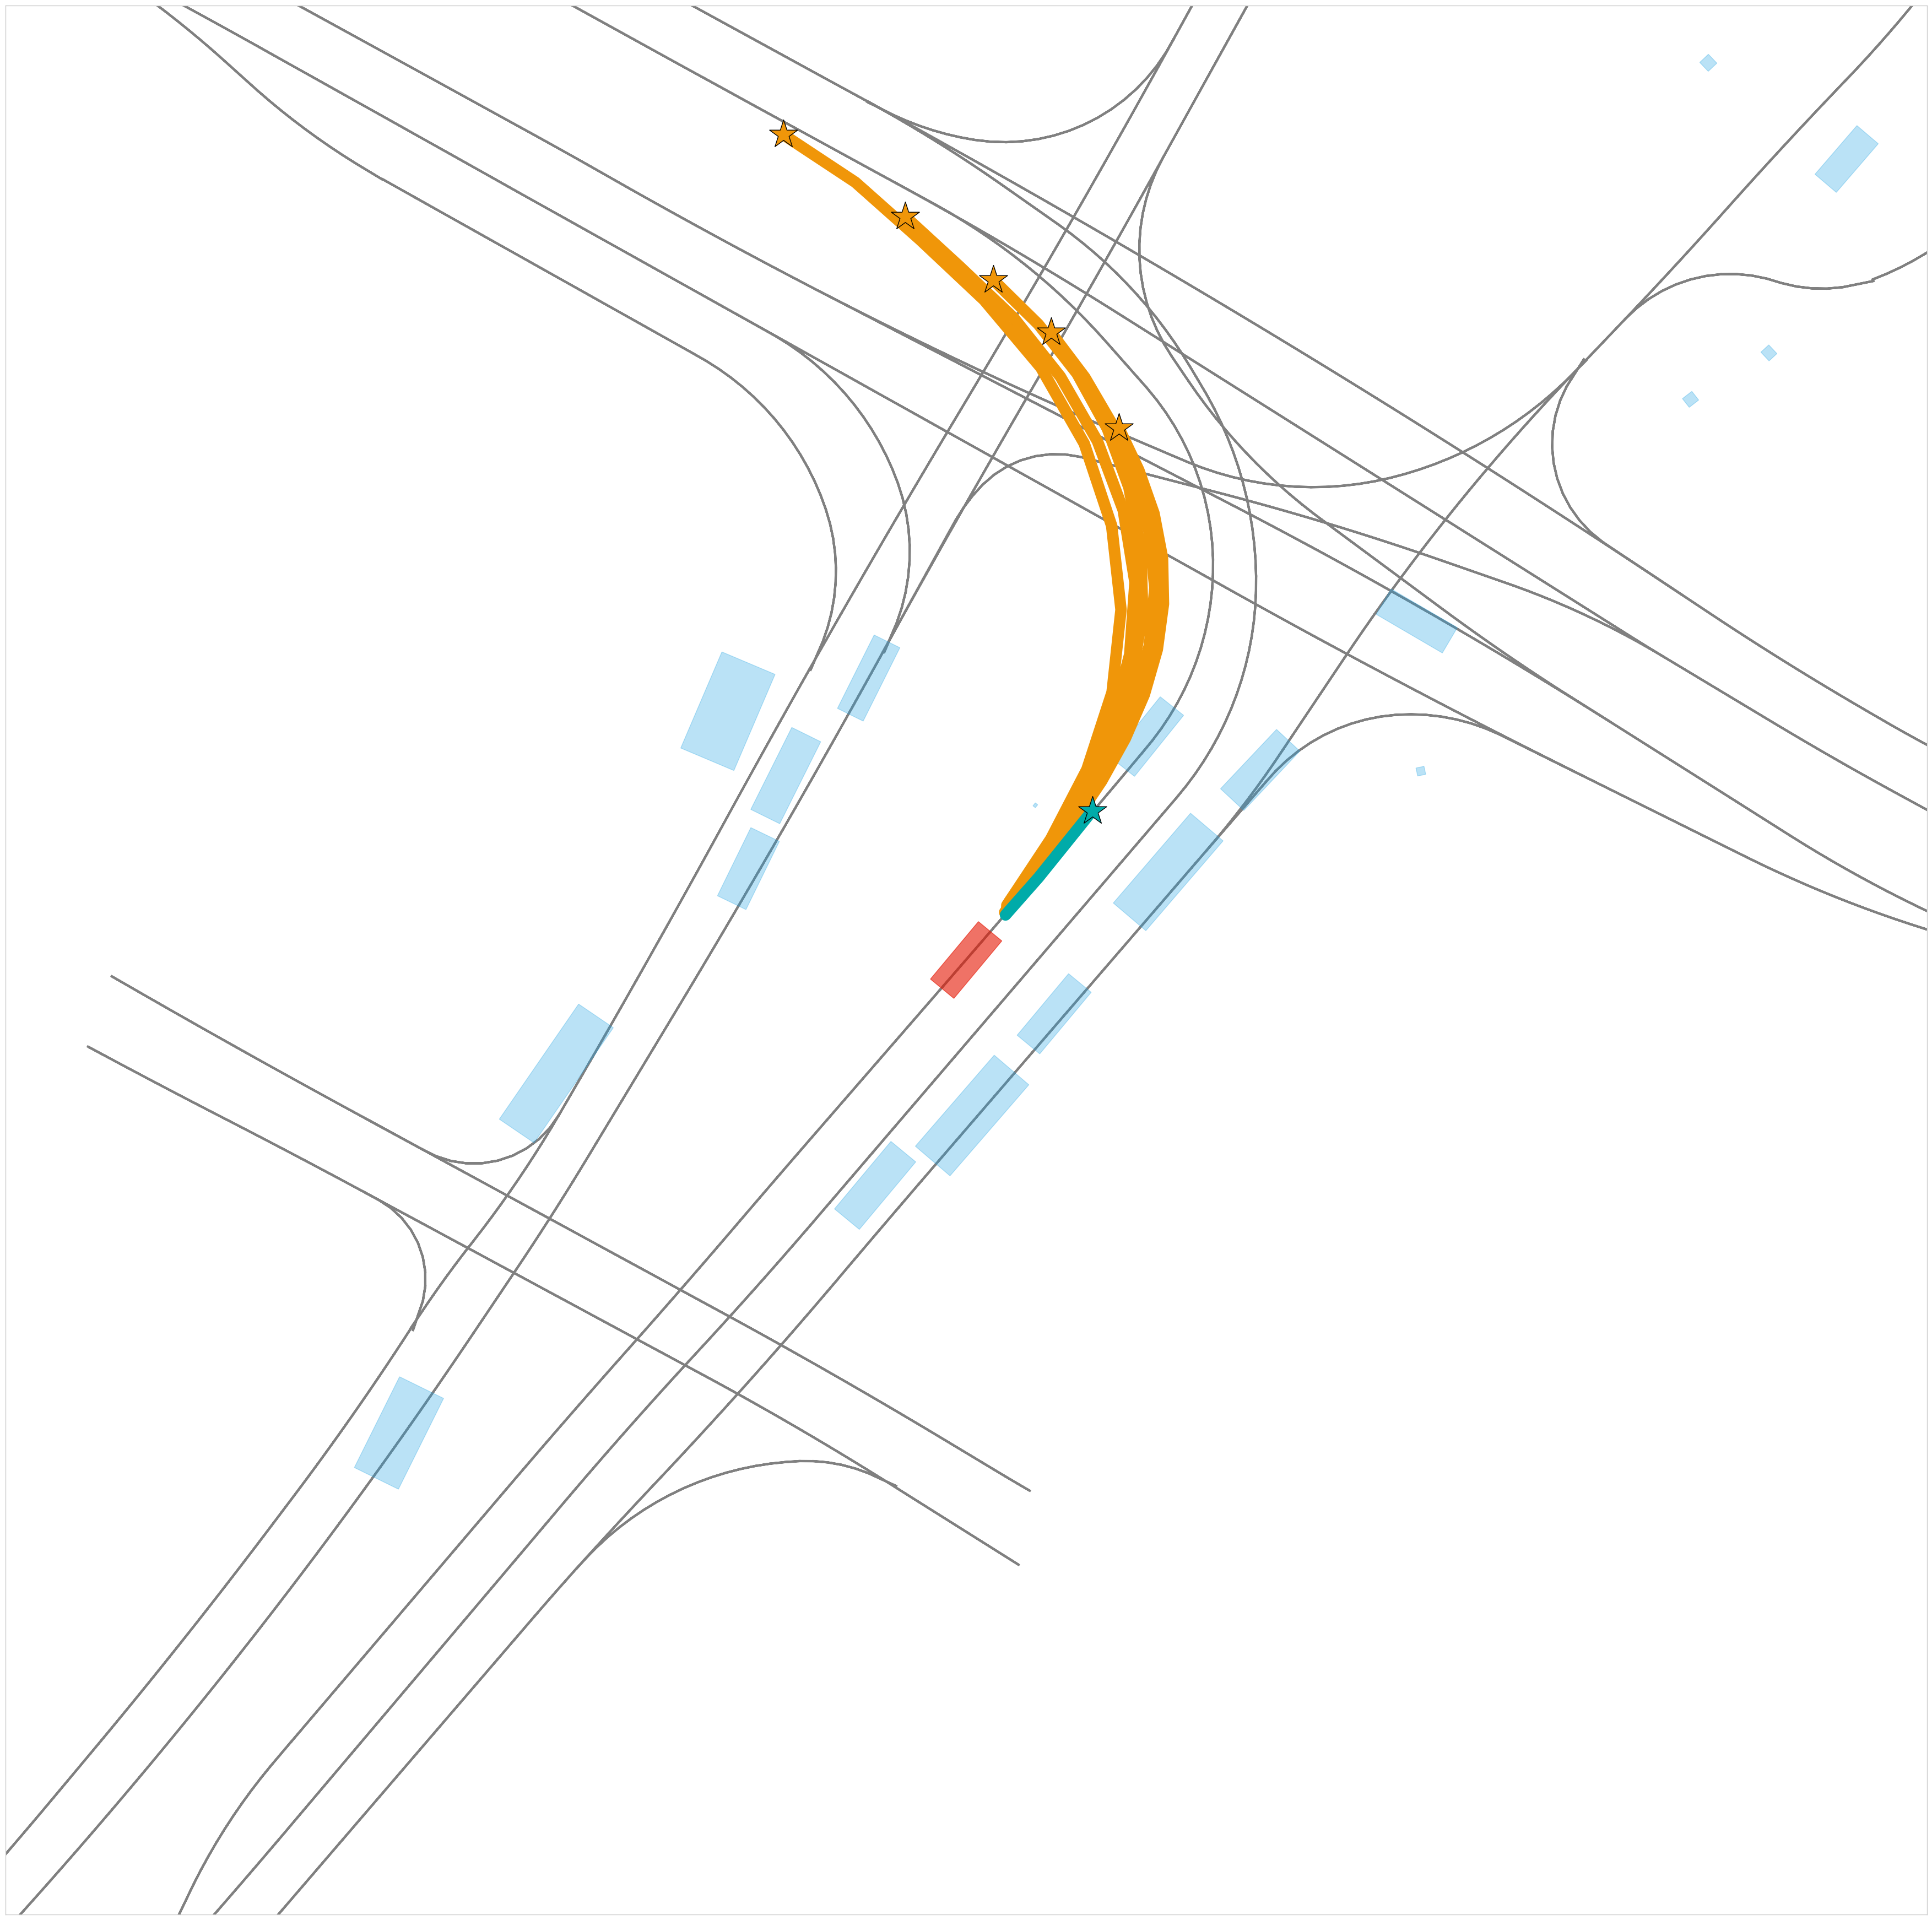

In [200]:
fig, ax = plt.subplots()
plot_scene_2(X[idx], helper, ax)

ax.plot(gt_x[idx], gt_y[idx], color = '#00ABA9', linewidth = 15, zorder = 10)
#ax.scatter(gt_x[idx][-1], gt_y[idx][-1], color = '#00ABA9', s = 15, marker = '*', zorder = 11)
ax.scatter(gt_x[idx][-1], gt_y[idx][-1], marker='*', s = 1500, color = '#00ABA9', linewidths = 1,edgecolors = 'black', zorder = 12)
for i in range(5):
    ax.plot(single_idx_x[i], single_idx_y[i], color = '#F09609', linewidth = 15)
    ax.scatter(single_idx_x[i][-1], single_idx_y[i][-1], marker='*', s = 1500, color = '#F09609', linewidths = 1,edgecolors = 'black', zorder = 11)
plt.xticks([])
plt.yticks([])

([], [])

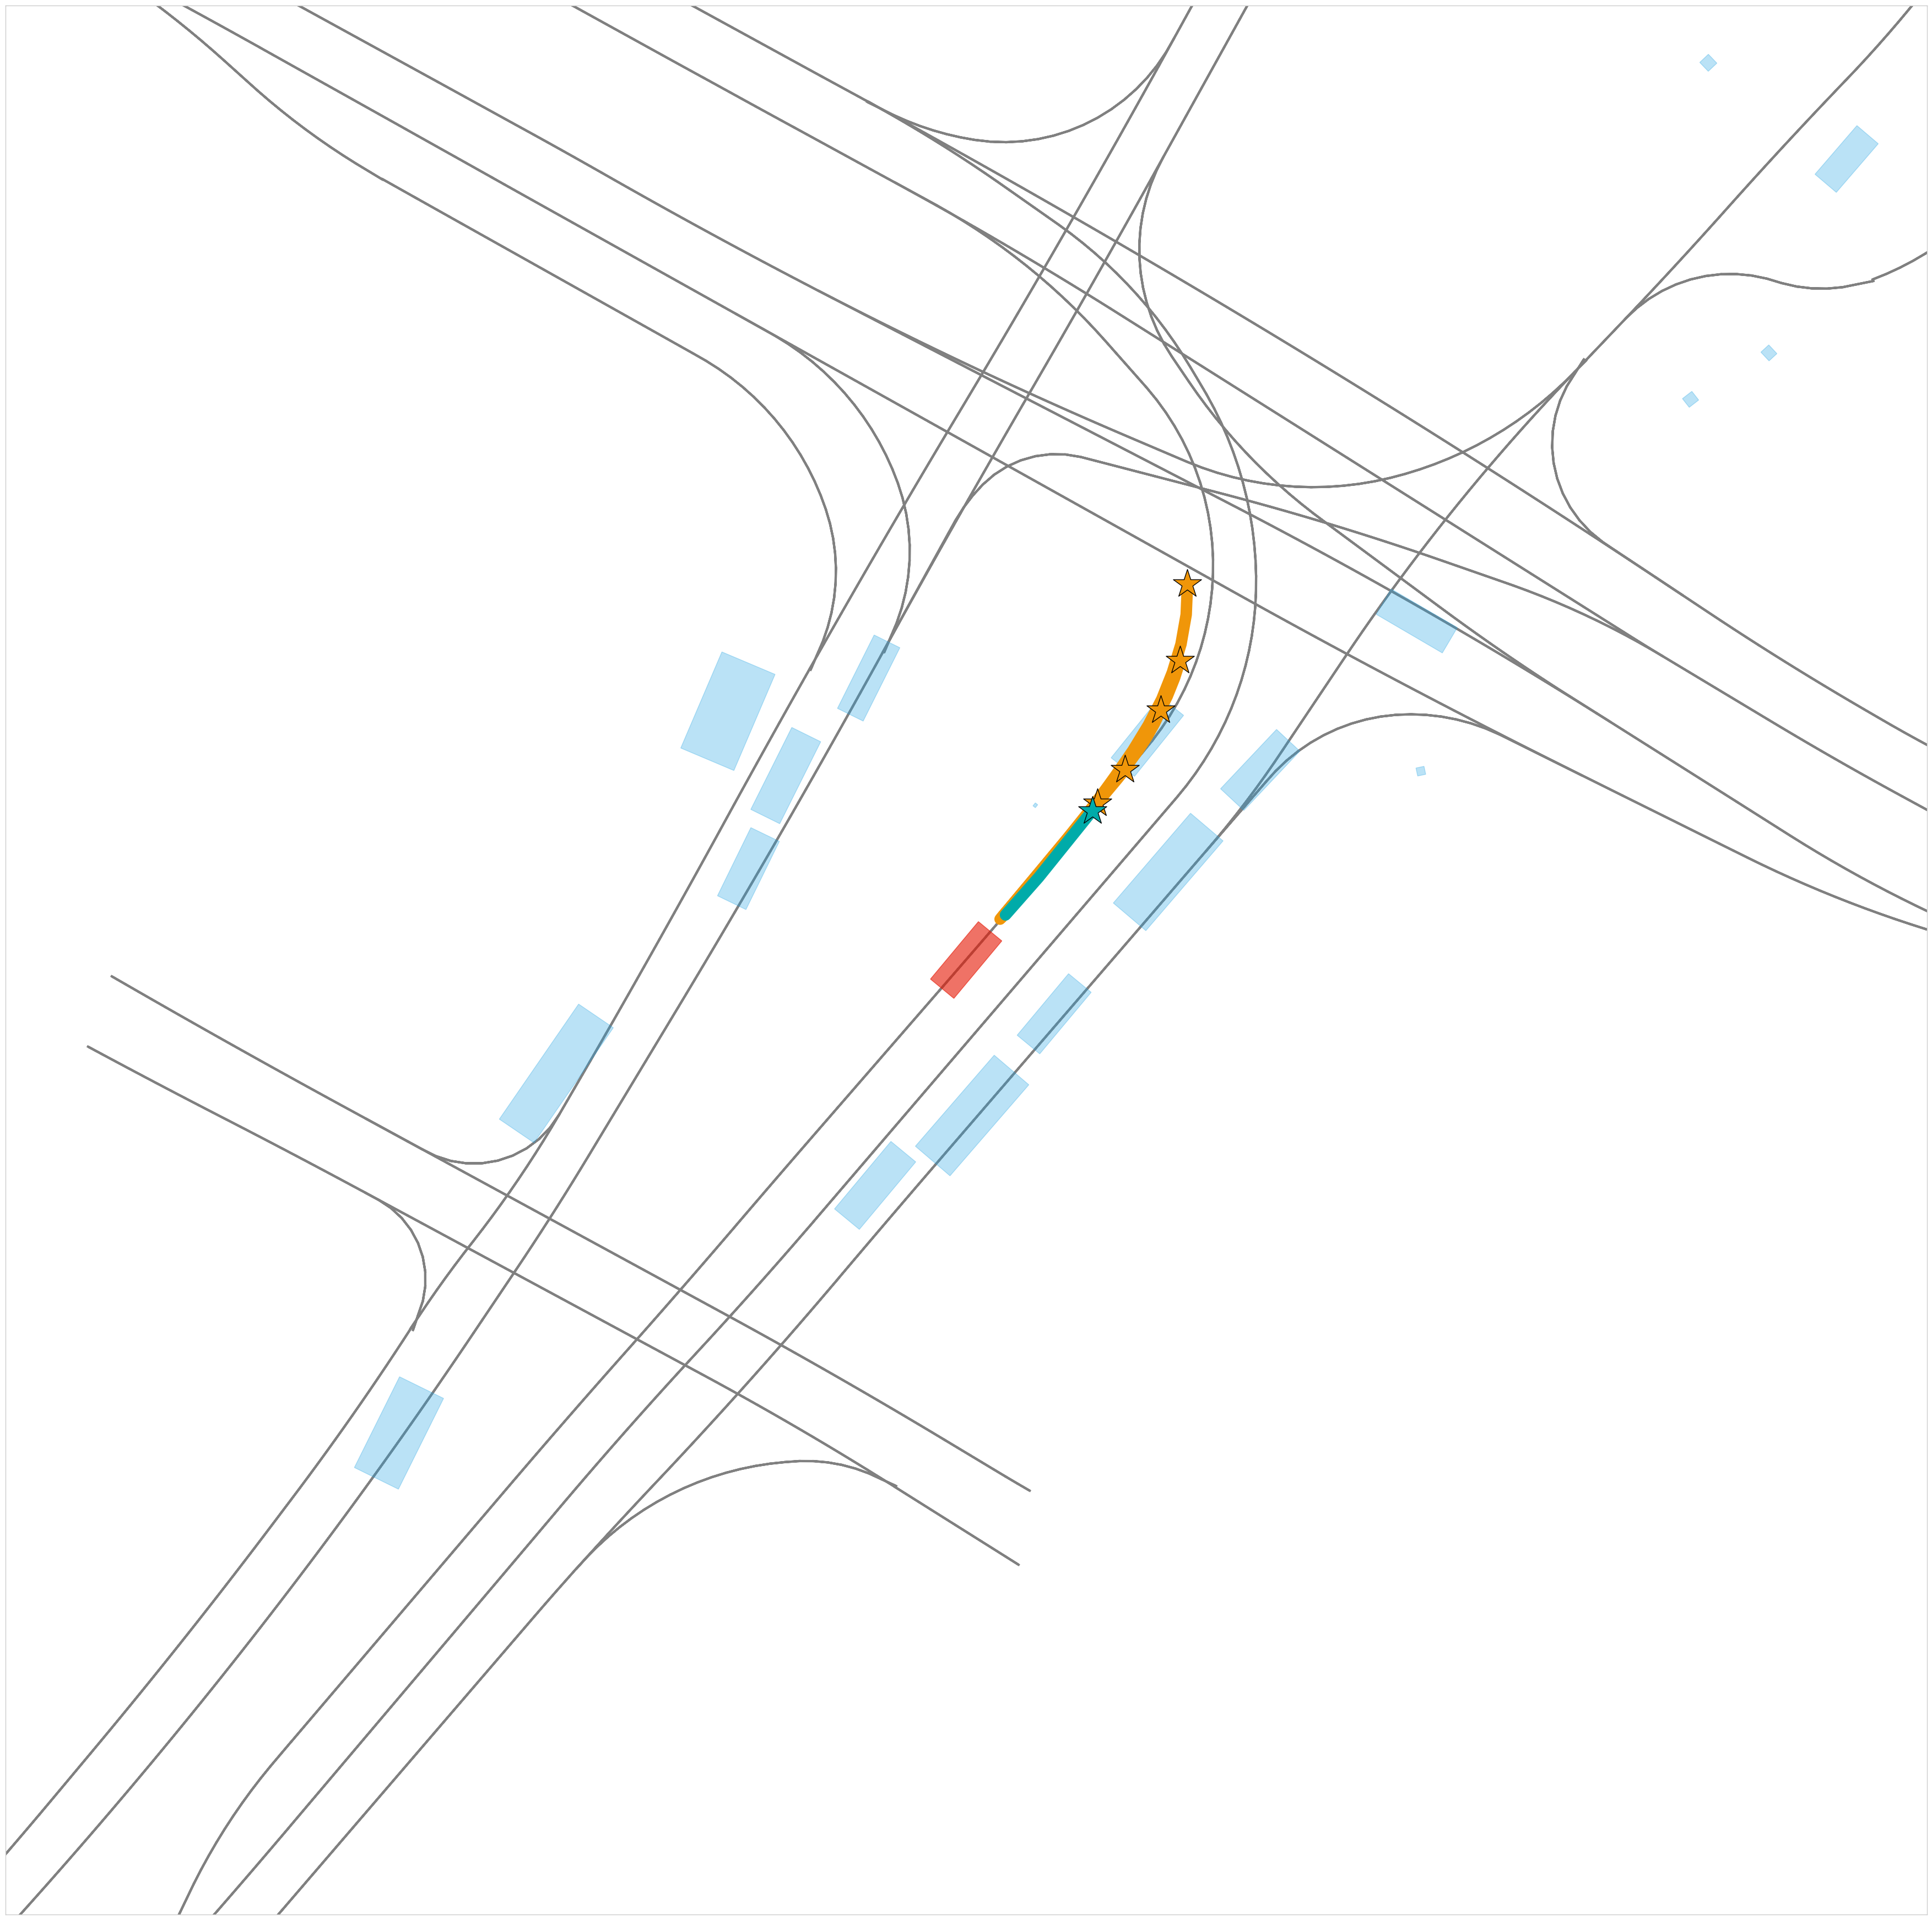

In [199]:
figsize(45,45)
fig, ax = plt.subplots()
plot_scene_2(X[idx], helper, ax)
ax.plot(gt_x[idx], gt_y[idx], color = '#00ABA9', linewidth = 15, zorder = 10)
#ax.scatter(gt_x[idx][-1], gt_y[idx][-1], color = '#00ABA9', s = 15, marker = '*', zorder = 11)
ax.scatter(gt_x[idx][-1], gt_y[idx][-1], marker='*', s = 1500, color = '#00ABA9', linewidths = 1,edgecolors = 'black', zorder = 12)
for i in range(5):
    ax.plot(social_idx_x[i], social_idx_y[i], color = '#F09609', linewidth = 15)
    ax.scatter(social_idx_x[i][-1], social_idx_y[i][-1], marker='*', s = 1500, color = '#F09609', linewidths = 1,edgecolors = 'black', zorder = 11)
plt.xticks([])
plt.yticks([])

In [162]:
def plot_agent(annotation, ax, clr = None, zorder = 2):
    width = annotation['size'][1]
    height = annotation['size'][0]
    translation = annotation['translation']
    xy = (translation[0] - width / 2, translation[1] - height / 2)
    angle = quaternion_yaw(Quaternion(annotation['rotation'])) / np.pi * 180
    if clr is None:
        clr = 'green'
    if clr == 'red' or clr == '#E51400':
        box = Rectangle(xy, width, height, angle = angle, rotation_point = 'center', color = clr, alpha = 0.6, zorder = zorder)
    else:
        box = Rectangle(xy, width, height, angle = angle, rotation_point = 'center', color = clr, alpha = 0.3, zorder = zorder)
    ax.add_patch(box)
    ax.set_xlim(translation[0] - 30, translation[0] + 30)
    ax.set_ylim(translation[1] - 30, translation[1] + 30)
def plot_lane(lane, closest_idx, ax, zorder = 1):
    x = []
    y = []
    yaw = []
    for node in lane:
        x.append(node.coors[0])
        y.append(node.coors[1])
        yaw.append(node.direction)
    for i in range(len(x) - 1):
        ax.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], length_includes_head = True, head_width = 0.0, color = 'gray', alpha = 1, linewidth = 3, linestyle = '-', zorder = zorder)
    ax.arrow(x[-1], y[-1], np.cos(yaw[-1]), np.sin(yaw[-1]), length_includes_head = True, head_width = 0.0, color = 'gray', alpha = 1, linewidth = 3, linestyle = '-', zorder = zorder)
    if closest_idx is not None:
        ax.scatter(x[closest_idx], y[closest_idx])
def plot_scene_2(ann, helper, ax):
    anns = helper.get_annotations_for_sample(ann['sample_token'])
    for t_ann in anns:
        if len(t_ann['attribute_tokens']):#没有attribute的情况
            attribute = nusc.get('attribute', t_ann['attribute_tokens'][0])
        else:
            attribute = None
        #print(attribute)
        #if 'vehicle' in attribute['name']:
        if t_ann['token'] == ann['token']:
            color = 'red'
            color = '#E51400'
        elif attribute is None or 'moving' in attribute['name'] or 'stopped' in attribute['name']:
            color = 'green'
            color = 'blue'
            color = '#1BA1E2'
        else:
            color = 'blue'
            color = '#1BA1E2'
        plot_agent(t_ann, ax, color, zorder = 2)
    figwidth = 60
    figheight = 60
    translation = ann['translation']
    ax.set_xlim(translation[0] - figwidth, translation[0] + figwidth)
    ax.set_ylim(translation[1] - figheight, translation[1] + figheight)
    map_name = helper.get_map_name_from_sample_token(ann['sample_token'])
    Vertices = Vertices_maps[map_name]
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    lanes_token = get_lanes_in_radius(translation[0], translation[1], max(figwidth, figheight), Vertices, Vertices_ordered_x, Vertices_ordered_y)
    
    for j in range(len(lanes_token)):
        lane_token = lanes_token[j]
        plot_lane(lanes_vertices[lane_token], None, ax, zorder = 1)

([], [])

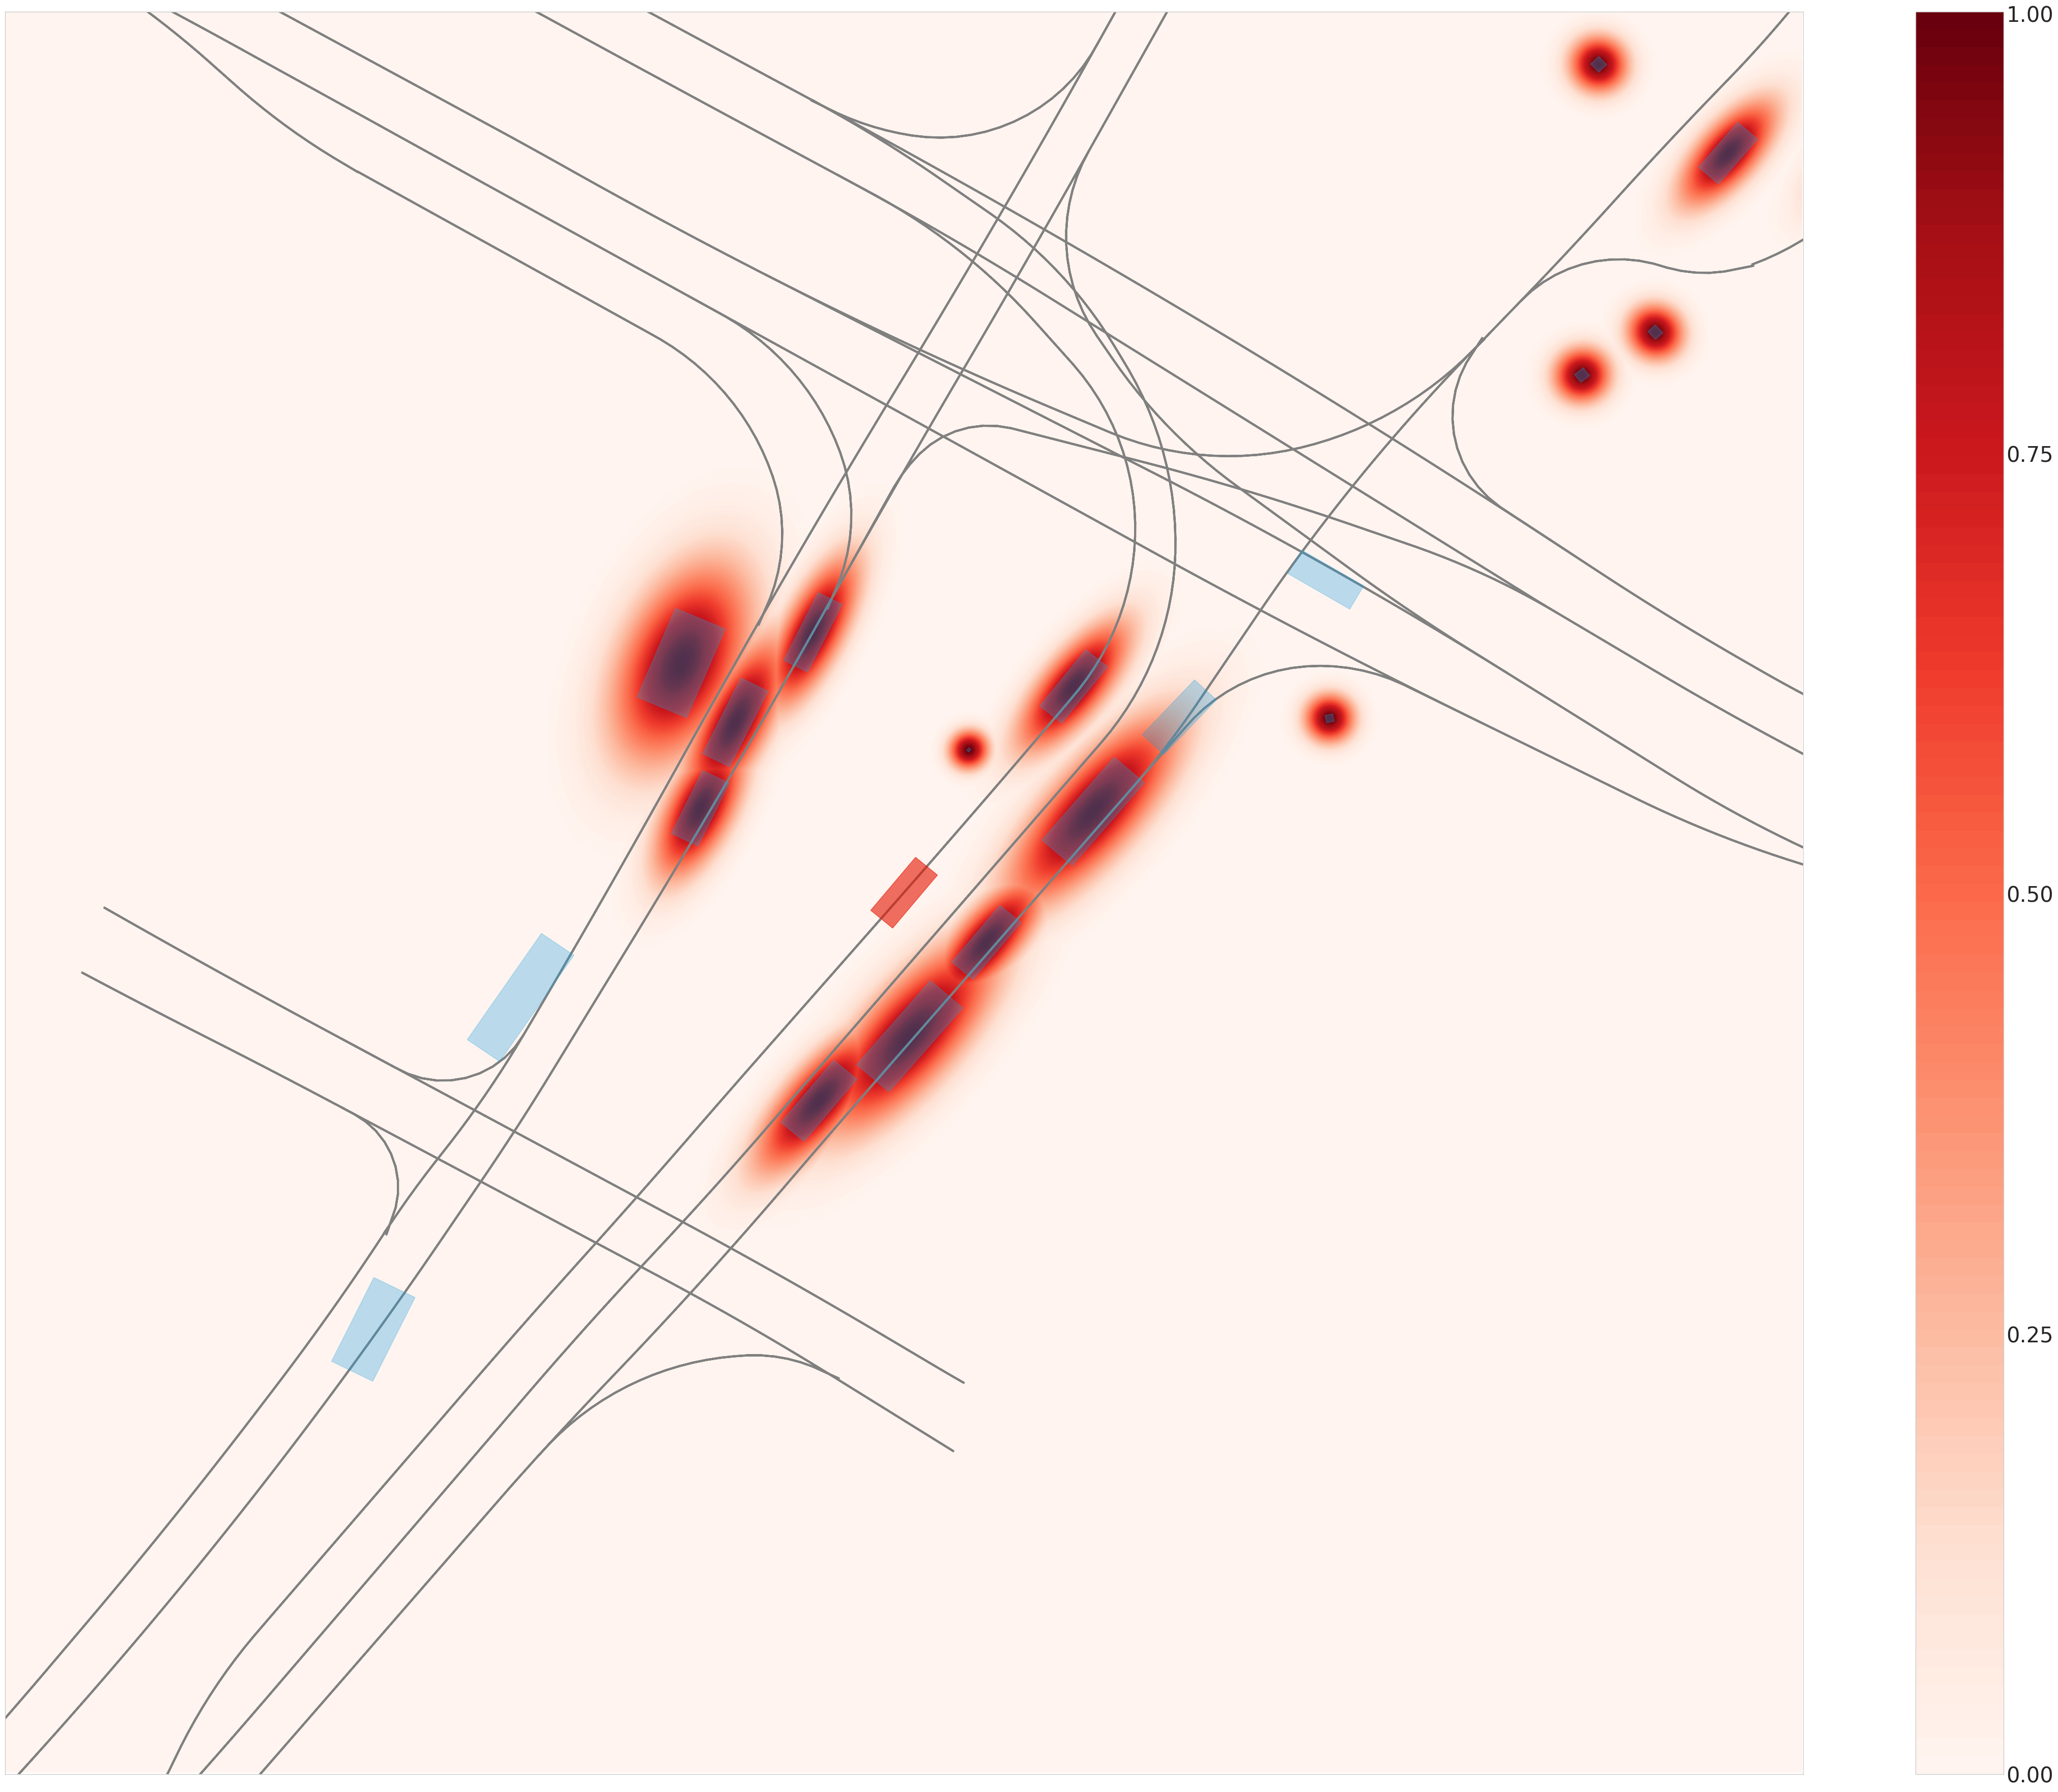

In [195]:
figsize(57,45)
levels = np.linspace(0,1.001,100)
radius = 60
fig, ax = plt.subplots()

main_agent = X[idx]
field_input = all_static[idx]
moving_vehicles = all_moving[idx]
moving_vehicles['sample_H'][-1] = 0
t_x = np.array(main_agent['translation'][0])
t_y = np.array(main_agent['translation'][1])
region_x = np.arange(t_x - radius, t_x + radius, 0.1)
region_y = np.arange(t_y + radius, t_y - radius, -0.1)
region_x, region_y = np.meshgrid(region_x, region_y)
field_risk = np.zeros_like(region_x, dtype=np.float64)

risk, risk_agents = total_field(region_x, region_y, **field_input)
field_risk = np.array([field_risk, risk_agents.max(axis = -1)]).max(axis = 0)
risk, risk_agents = total_field(region_x, region_y, **moving_vehicles)
#field_risk += risk
field_risk = np.array([field_risk, risk_agents.max(axis = -1)]).max(axis = 0)
CS1 = plt.contourf(region_x, region_y, field_risk, cmap = plt.cm.Reds, levels = levels, extend = 'neither', alpha = 1, zorder=0)

cb1 = plt.colorbar(CS1)
cb1.set_ticks([0, 0.25,0.5, 0.75, 1])
cb1.ax.tick_params(labelsize=30) 
plot_scene_2(X[idx], helper, ax)
plt.xticks([])
plt.yticks([])
#ax.set_xlim((region_x[0][0], region_x[-1][-1]))
#ax.set_ylim((region_y[-1][-1], region_y[0][0]))

In [145]:
risk_agents.shape

(600, 600, 11)

In [50]:
figsize(15,15)
for i in range(len(main_x)):
    if comp[i] > 2:
        total_i = i
        fig, ax = plt.subplots()
        plot_scene(X[total_i], helper, ax)
        ax.plot(gt_x[total_i], gt_y[total_i], color = 'red')
        #ax.scatter(main_x[i], main_y[i], s= 1, alpha=0.5)
        fig.savefig('./val_social_comp/fig_{}_pred_all.png'.format(total_i))
        plt.close()

In [53]:
figsize(15,15)
for i in range(len(main_x)):
    if comp[i] > 2:
        total_i = i
        fig, ax = plt.subplots()
        plot_scene(X[total_i], helper, ax)
        ax.plot(gt_x[total_i], gt_y[total_i], color = 'red')
        ax.scatter(main_x[i], main_y[i], s= 1, alpha=0.5)
        fig.savefig('./val_social_comp/fig_{}_pred_all_social.png'.format(total_i))
        plt.close()

In [54]:
figsize(15,15)
for i in range(len(main_x)):
    if comp[i] > 2:
        total_i = i
        fig, ax = plt.subplots()
        plot_scene(X[total_i], helper, ax)
        ax.plot(gt_x[total_i], gt_y[total_i], color = 'red')
        ax.scatter(single_main_x[i], single_main_y[i], s= 1, alpha=0.5)
        fig.savefig('./val_social_comp/fig_{}_pred_all_single.png'.format(total_i))
        plt.close()

In [35]:
ade_5_social = ade_5

In [30]:
(ade_5[:,:,-1].min(axis = 1) > 2).sum() / len(X)

0.5866607676142019

In [46]:
figsize(15,15)
from sklearn.cluster import AgglomerativeClustering

pred_10_x = []
pred_10_y = []
pred_10 = []
n_clusters = 10
n_res = 10
for i in range(len(main_x)):
    #clear_output()
    #print(i)

    pred_x = main_x[i]
    pred_y = main_y[i]
    num_samples = len(pred_x)
    pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward').fit(pred_nodes)
    labels = clustering.labels_
    agent_x = []
    agent_y = []
    rank = []
    for j in range(n_clusters):
        rank.append(((labels == j).sum(), j))
    rank = sorted(rank, reverse = True)
    for j in range(n_res):
        mask = labels == rank[j][1]
        temp_x = pred_x[mask]
        temp_x = temp_x.mean(axis = 0)
        temp_y = pred_y[mask]
        temp_y = temp_y.mean(axis = 0)
        agent_x.append(temp_x)
        agent_y.append(temp_y)
    pred_10_x.append(agent_x)
    pred_10_y.append(agent_y)
 

In [47]:
x_diffs = (np.array(pred_10_x) - np.expand_dims(c_gt_x, 1))
y_diffs = (np.array(pred_10_y) - np.expand_dims(c_gt_y, 1))
ade_10 = np.sqrt(x_diffs ** 2 + y_diffs ** 2)
ade_10.mean(axis = 2).min(axis = 1).mean()

1.3825535319316813

In [48]:
ade_10[:,:,-1].min(axis=1).mean()

2.388753070793214

In [33]:
(ade_10[:,:,-1].min(axis = 1) > 2).sum() / len(X)

0.36677358699258933

In [ ]:
ade_10[:,:,-1].min(axis = 1).mean()

In [ ]:
x_diffs = ans_x.mean(axis=1) - gt_x
y_diffs = ans_y.mean(axis=1) - gt_y
ade_1 = np.sqrt(x_diffs ** 2 + y_diffs ** 2)

In [ ]:
ade_1.shape

In [ ]:
ade_1.mean(axis=1).mean()

In [ ]:
pred_5_x = np.array(pred_5_x)
pred_5_y = np.array(pred_5_y)
pred_10_x = np.array(pred_10_x)
pred_10_y = np.array(pred_10_y)

In [ ]:
figsize(15,15)
color = ['b','g','r','m','k','c','y']
def get_histroy(ins_sample_token):
    instance_token, sample_token = ins_sample_token.split('_')
    past_xy_global = helper.get_past_for_agent(instance_token, sample_token, seconds=2, in_agent_frame=False)
    past_xy_global = past_xy_global[::-1]
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x_y = np.array([ann['translation'][:2]])
    return np.concatenate([past_xy_global, x_y], axis = 0)
for idx in range(len(X)):
    ann = X[idx]
    instance_token, sample_token = token_list[idx].split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    map_name = helper.get_map_name_from_sample_token(sample_token)
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    Vertices = Vertices_maps[map_name]
    Edges = Edges_maps[map_name]
    for j in range(len(pred_5_x[idx])):
        plt.scatter(pred_5_x[idx][j].reshape(-1), pred_5_y[idx][j].reshape(-1), s = 5)
    plt.scatter(gt_x[idx], gt_y[idx], marker='*', s = 50)
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    history = get_histroy(token_list[idx])
    nodes = get_nodes_in_radius(*ann['translation'][:2], 50, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    plt.scatter(history[:,0], history[:, 1], marker= 'x', s = 50)

    for node in nodes:
        node_1 = Vertices[node]
        #plt.scatter(node_1.coors[0], node_1.coors[1])
        for i in node_1.next:
            node_2 = Vertices[i]
            if node_1.lane_token == node_2.lane_token:
                plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[0])
            #else:
            #    plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[1])
    plt.xlim(gt_x[idx][0] - 30, gt_x[idx][0] + 30)
    plt.ylim(gt_y[idx][0] - 30, gt_y[idx][0] + 30)
    plt.savefig('./predict_3.20_3_4/fig_{}_pred_5.png'.format(idx))
    plt.close()
    print(idx)

In [ ]:
figsize(15,15)
color = ['b','g','r','m','k','c','y']
def get_histroy(ins_sample_token):
    instance_token, sample_token = ins_sample_token.split('_')
    past_xy_global = helper.get_past_for_agent(instance_token, sample_token, seconds=2, in_agent_frame=False)
    past_xy_global = past_xy_global[::-1]
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x_y = np.array([ann['translation'][:2]])
    return np.concatenate([past_xy_global, x_y], axis = 0)
for idx in range(len(X)):
    ann = X[idx]
    instance_token, sample_token = token_list[idx].split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    map_name = helper.get_map_name_from_sample_token(sample_token)
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    Vertices = Vertices_maps[map_name]
    Edges = Edges_maps[map_name]
    for j in range(len(pred_10_x[idx])):
        plt.scatter(pred_10_x[idx][j].reshape(-1), pred_10_y[idx][j].reshape(-1), s = 5)
    plt.scatter(gt_x[idx], gt_y[idx], marker='*', s = 50)
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    history = get_histroy(token_list[idx])
    nodes = get_nodes_in_radius(*ann['translation'][:2], 50, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    plt.scatter(history[:,0], history[:, 1], marker= 'x', s = 50)

    for node in nodes:
        node_1 = Vertices[node]
        #plt.scatter(node_1.coors[0], node_1.coors[1])
        for i in node_1.next:
            node_2 = Vertices[i]
            if node_1.lane_token == node_2.lane_token:
                plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[0])
            #else:
            #    plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[1])
    plt.xlim(gt_x[idx][0] - 30, gt_x[idx][0] + 30)
    plt.ylim(gt_y[idx][0] - 30, gt_y[idx][0] + 30)
    plt.savefig('./predict_3.20_3_4/fig_{}_pred_10.png'.format(idx))
    plt.close()
    print(idx)